In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.dataset import bulkDataset
from upsetplot import UpSet
from src.visualization.plot import *
from src.settings import *
plt.style.use(PlotStyle)
%load_ext autoreload
%autoreload 2

In [2]:
data_processed_folder = '../data/processed'
dataset = bulkDataset(data_processed_folder)
metadata= dataset.metadata
somatic_mutation = dataset.load('somatic_mutation')

  2024-06-03 12:19:58,446 - src.dataset._dataset - _getMetadata - INFO - Appending clinical_and_sequencing_metadata feature estimated from clinical_sequencing sequencing into metadata
  2024-06-03 12:19:58,455 - src.dataset._dataset - _getMetadata - INFO - Appending mutation_signature feature estimated from WES sequencing into metadata
  2024-06-03 12:19:58,460 - src.dataset._dataset - _getMetadata - INFO - Attaching WES prefix to feature names in mutation_signature
  2024-06-03 12:19:58,461 - src.dataset._dataset - _getMetadata - INFO - Appending somatic_mutation_burden feature estimated from WES sequencing into metadata
  2024-06-03 12:19:58,465 - src.dataset._dataset - _getMetadata - INFO - Attaching WES prefix to feature names in somatic_mutation_burden
  2024-06-03 12:19:58,466 - src.dataset._dataset - _getMetadata - INFO - Appending cga_wes_features feature estimated from WES sequencing into metadata
  2024-06-03 12:19:58,470 - src.dataset._dataset - _getMetadata - INFO - Attachi

In [3]:
metadata.loc[metadata.BulkRNA_Profile, 'Timepoint'].unique()
mutsigcv = dataset.load('MutSigCV')

# Overview of the data
## Patients that do not have the RCB status

- Pt17 withdrew consent.
- Pt22 is metastatic and was not having breast surgery.
- Pt25 switched to SOC. also HER2+

## Inclusion of patients in the analysis

1. Remove 1 samples from P25 which is HER2+ for all the analysis.
2. Pt17 and Pt22 baseline samples were included in the mutation landscape analysis.
3. Pt17 and Pt22 were excluded in both response and treatment exposure analysis.

In [4]:
metadata.loc[metadata.Patient.isin(['P17','P22','P25']),['Patient','Timepoint','BestResponse','her2']]

,Patient,Timepoint,BestResponse,her2
RP-2423_16466_22_110719,P22,Baseline,N/A,Negative
RP-2423_16466_22_112619,P22,W3D1,N/A,Negative
RP-2423_16466_22_022020,P22,Surg+AC,N/A,Negative
RP-2423_16466_22_122719,P22,W7D1,N/A,Negative
RP-2423_16466_17_062519,P17,Baseline,N/A,Negative


# Define the Figure and Table output

In [5]:
WesTableFile = '../report/table/Table_1_trial_16-466_WES_Data.xlsx'

# WES QC

In [6]:
wes = metadata.loc[metadata.WES_Profile==True,:]
wes.index.name='SampleID'
wes_sheets = {
    'TableA WES_QC_Metrics':wes.loc[:,metadata.columns.str.contains('WES')].copy()
}

## WES QC figure

Samples with TiN > 0.3: N = 0


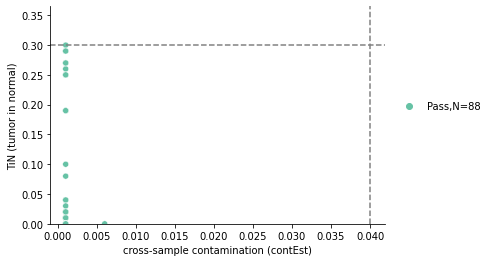

In [7]:
# TiN: Tumor-in-Normal (TiN) contamination level
# TiN > 0.3 is not safe, from the VA lab TWIST pipeline summary slide 3
tin_cutoff = 0.3
contEst_cutoff = 0.04
tb = wes.copy()
tb['TiN_Fail'] = tb['WES_combined_TiN'] >tin_cutoff
tb['TiN_Fail_Label'] = tb['TiN_Fail'].map(lambda x: 'Fail' if x else 'Pass')
total_n = tb['TiN_Fail_Label'].value_counts().to_dict()
tb['TiN_Fail_Label'] = tb['TiN_Fail_Label'].map(lambda x: f'{x},N={total_n[x]}')
ax = sns.scatterplot(data=tb,y='WES_combined_TiN',x='WES_combined_fracContam',hue='TiN_Fail_Label',palette='Set2')
# ax.set_xlim([0,tb.shape[0]+1])
ax.set_ylim([0,ax.get_ylim()[1]+0.05])
ax.axhline(y=tin_cutoff,linestyle='--',color='gray')
ax.axvline(x=contEst_cutoff,linestyle='--',color='gray')
ax.legend(loc=(1.03,0.5),title='',frameon=False)
ax.set(ylabel='TiN (tumor in normal)',xlabel='cross-sample contamination (contEst)')
print(f'Samples with TiN > {tin_cutoff}: N =', tb['TiN_Fail'].sum())

In [8]:
wes = wes.loc[
    (wes.WES_combined_TiN<=tin_cutoff)&
    (wes.WES_combined_fracContam<=contEst_cutoff),:]

## Sample distribution after WES QC

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

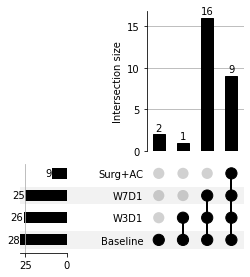

In [9]:
upset_dt=pd.crosstab(wes['Patient'],wes['Timepoint'])
upset_dt = upset_dt.set_index(upset_dt.columns.tolist())
upset = UpSet(upset_dt, show_counts=True)
upset.plot()

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

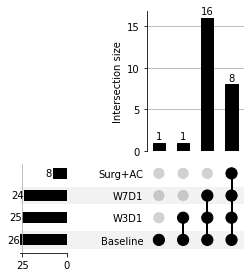

In [10]:
upset_dt=pd.crosstab(wes['Patient'],wes['Timepoint'])
upset_dt = upset_dt.loc[~upset_dt.index.isin(['P17','P22']),:]
upset_dt = upset_dt.set_index(upset_dt.columns.tolist())
upset = UpSet(upset_dt, show_counts=True)
upset.plot()

## Basic genomic feature distribution

In [11]:
wes.loc[wes.Timepoint=='Baseline',[
    'WES_Nonsynonymous_TMB',
    'WES_absolute_purity',
    'WES_absolute_ploidy'
     ]].describe()

,WES_Nonsynonymous_TMB,WES_absolute_purity,WES_absolute_ploidy
count,28.000000,28.000000,28.000000
mean,3.092832,0.405000,2.925000
std,3.728314,0.181791,1.078392
min,0.901865,0.130000,1.700000
25%,1.557875,0.277500,2.000000
50%,2.198600,0.375000,3.075000
75%,2.939469,0.532500,3.532500
max,20.163020,0.870000,5.510000


## Dominant WES signature

In [12]:
wes['WES_Dominant_Mutation_Signature']=wes.loc[:,wes.columns.str.startswith('WES_SBS')].dropna().idxmax(axis=1)

In [13]:
dominant_sig = wes.loc[wes.Timepoint=='Baseline','WES_Dominant_Mutation_Signature'].value_counts()
dominant_sig.map(lambda x: f"{x}/{dominant_sig.sum()} patients, {x/dominant_sig.sum():.2%}")

WES_SBS5     7/28 patients, 25.00%
WES_SBS46    5/28 patients, 17.86%
WES_SBS1     5/28 patients, 17.86%
WES_SBS39    3/28 patients, 10.71%
WES_SBS2      2/28 patients, 7.14%
WES_SBS15     2/28 patients, 7.14%
WES_SBS3      1/28 patients, 3.57%
WES_SBS42     1/28 patients, 3.57%
WES_SBS6      1/28 patients, 3.57%
WES_SBS96     1/28 patients, 3.57%
Name: WES_Dominant_Mutation_Signature, dtype: object

In [14]:
aetiology = pd.read_csv(HERE/'external/cosmic_v3_aetiology.csv',index_col=0)
aetiology.index = aetiology.index.str.replace('SBS','WES_SBS').str.replace('[a-z]$','',regex=True)
aetiology = aetiology.reset_index().drop_duplicates().set_index('index')
aetiology = aetiology['aetiology'].str.capitalize().to_dict()
aetiology['WES_SBS39'] = aetiology['WES_SBS3']
aetiology['WES_SBS96'] = 'Unknown'
dominant_sig.index = dominant_sig.index.str.replace('[a-z]$','',regex=True).map(lambda x:f"{x}:{aetiology[x]}")
dominant_sig.map(lambda x: f"{x}/{dominant_sig.sum()} patients, {x/dominant_sig.sum():.2%}")

WES_SBS5:Unknown                                                     7/28 patients, 25.00%
WES_SBS46:Possible sequencing artefact                               5/28 patients, 17.86%
WES_SBS1:Spontaneous or enzymatic deamination of 5-methylcytosine    5/28 patients, 17.86%
WES_SBS39:Defects in dna-dsb repair by hr                            3/28 patients, 10.71%
WES_SBS2:Apobec cytidine deaminase (c>t)                              2/28 patients, 7.14%
WES_SBS15:Defective dna mismatch repair                               2/28 patients, 7.14%
WES_SBS3:Defects in dna-dsb repair by hr                              1/28 patients, 3.57%
WES_SBS42:Occupational exposure to haloalkanes                        1/28 patients, 3.57%
WES_SBS6:Defective dna mismatch repair                                1/28 patients, 3.57%
WES_SBS96:Unknown                                                     1/28 patients, 3.57%
Name: WES_Dominant_Mutation_Signature, dtype: object

## WES Mutation Frequency

In [15]:
mut_freq = pd.read_csv('../data/processed/mutation_frequency_stats.csv')
mut_freq.loc[(mut_freq.Timepoint=='Baseline')&
                  (mut_freq.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),
                  :].sort_values('N_Mut',ascending=False).head(15)

,Gene,Freq_mutation,N_sample,N_Mut,Treatment_Arm,Timepoint
3932,TP53,0.428571,28,12,"Chemo->ICI,ICI->Chemo",Baseline
3933,TTN,0.285714,28,8,"Chemo->ICI,ICI->Chemo",Baseline
3934,VPS13B,0.250000,28,7,"Chemo->ICI,ICI->Chemo",Baseline
3935,OBSCN,0.178571,28,5,"Chemo->ICI,ICI->Chemo",Baseline
3936,GATA3,0.178571,28,5,"Chemo->ICI,ICI->Chemo",Baseline
3940,MAP3K1,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline
3942,MUC16,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline
3941,RELN,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline
3943,ADAMTSL4,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline
3939,ZNF469,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline


['GATA3', 'TP53', 'TTN', 'OBSCN', 'USP35', 'MUC16', 'MKL1', 'VPS13B']

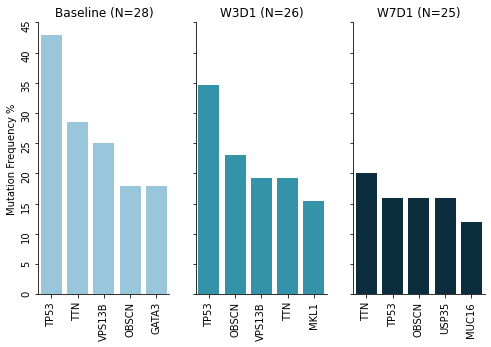

In [16]:
top_genes = []
fig,axs = plt.subplots(1,3,figsize=(8,5),sharey=True)
for i,(timepoint, df) in enumerate(mut_freq.loc[
    (mut_freq.Timepoint.isin(['Baseline','W3D1','W7D1']))&
    (mut_freq.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),:].groupby('Timepoint')):
    ax= axs[i]
    df = df.sort_values('N_Mut',ascending=False).head(5)
    df['Freq_mutation'] = df['Freq_mutation'] * 100
    sns.barplot(data=df,y='Freq_mutation',x='Gene',ax=ax,
                color=COLOR_PAlETTE['Timepoint'][timepoint])
    ylabel='' if i >0 else 'Mutation Frequency %'
    ax.set(xlabel='',ylabel=ylabel,title=f"{timepoint} (N={df.N_sample.values[0]})")
    ax.tick_params(rotation=90)
    top_genes = top_genes + df.Gene.tolist()
top_genes = list(set(top_genes))
display(top_genes)

In [17]:
mut_freq.loc[(mut_freq.Gene=='PIK3CA')&
             (mut_freq.Timepoint=='Baseline'),:]

,Gene,Freq_mutation,N_sample,N_Mut,Treatment_Arm,Timepoint
3937,PIK3CA,0.142857,28,4,"Chemo->ICI,ICI->Chemo",Baseline
9236,PIK3CA,0.142857,14,2,Chemo->ICI,Baseline
11822,PIK3CA,0.142857,14,2,ICI->Chemo,Baseline


In [18]:
mutsigcv.loc[mutsigcv.gene.isin(top_genes+['PIK3CA']),:]

,rank,gene,longname,codelen,nnei,nncd,nsil,nmis,nstp,nspl,nind,nnon,npat,nsite,pCV,pCL,pFN,p,q
0,1,TP53,tumor protein p53,1890,87,0,0,9,1,0,2,12,11,12,1.892571e-14,1.000,0.00960,2.819966e-14,5.159411e-10
1,2,GATA3,GATA binding protein 3,1351,433,0,0,2,0,0,4,6,6,6,1.530146e-08,1.000,0.29000,1.282278e-07,1.173028e-03
6,7,MKL1,megakaryoblastic leukemia (translocation) 1,2844,94,0,0,3,0,0,0,3,3,1,3.871218e-04,0.001,0.56096,6.102792e-06,1.595095e-02
7,8,USP35,ubiquitin specific peptidase 35,3097,109,0,0,4,0,0,0,4,4,3,2.590304e-05,0.026,0.37500,7.263564e-06,1.661177e-02
307,308,VPS13B,vacuolar protein sorting 13 homolog B (yeast),12503,2,0,0,4,0,1,1,6,6,6,1.386857e-02,1.000,0.44800,4.325811e-02,1.000000e+00
430,431,PIK3CA,"phosphoinositide-3-kinase, catalytic, alpha po...",3287,2,0,0,7,0,0,0,7,5,6,2.431317e-01,0.040,0.22400,5.702362e-02,1.000000e+00
2055,2056,OBSCN,"obscurin, cytoskeletal calmodulin and titin-in...",25533,1,2,0,5,0,0,1,6,6,6,1.983895e-01,1.000,0.60300,5.192892e-01,1.000000e+00
2128,2129,MUC16,"mucin 16, cell surface associated",43858,0,0,2,4,0,0,0,4,4,4,7.195301e-01,1.000,0.44800,7.440977e-01,1.000000e+00
2134,2135,TTN,titin,111447,1,1,2,9,0,0,0,9,7,9,9.530543e-01,1.000,0.38900,7.667753e-01,1.000000e+00


## Single gene predictor

In [19]:
dataset.load('mutation_Response').sort_values('Pvalue').head(20)

,category,Zscore,Pvalue,Method,padj,Timepoint,Treatment_Arm,Comparison,N_Sample
5,ABCA13,1.785285,0.074215,GLM-Binomial,0.999124,Baseline,Chemo->ICI,"0-I:1,II-III:0","0.0:10,1.0:3"
7261,ABCA13,1.574680,0.115330,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
10393,TICRR,1.419998,0.155608,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
7423,ANKRD53,1.412089,0.157924,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
8699,IL17C,1.412089,0.157924,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
10051,SHROOM3,1.394720,0.163100,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
8078,DFFB,1.350444,0.176874,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
3385,VPS13B,1.348228,0.177585,GLM-Binomial,0.999124,Baseline,Chemo->ICI,"0-I:1,II-III:0","0.0:10,1.0:3"
9609,PITPNM1,1.280201,0.200474,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"
9402,OBSCN,1.248464,0.211861,GLM-Binomial,0.999257,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:20,1.0:6"


## WES features association with response


### Test the Defects in dna-dsb repair by hr signature association

In [20]:
from scipy.stats import fisher_exact
[ (k,v) for k,v in aetiology.items() if 'hr' in v]

[('WES_SBS3', 'Defects in dna-dsb repair by hr'),
 ('WES_SBS39', 'Defects in dna-dsb repair by hr')]

In [21]:
timepoint ='Baseline'
data = wes.loc[(wes.Timepoint==timepoint)&(wes.BestResponse!='N/A'),
               ['BestResponse','WES_Dominant_Mutation_Signature']].copy()
data = pd.get_dummies(data,columns=['WES_Dominant_Mutation_Signature'])
data['Defects in dna-dsb repair by hr'] = data[['WES_Dominant_Mutation_Signature_WES_SBS3','WES_Dominant_Mutation_Signature_WES_SBS39']].sum(axis=1)
table = pd.crosstab(data['BestResponse'],data['Defects in dna-dsb repair by hr'])
display(table)
fisher_exact(table)

Defects in dna-dsb repair by hr,0,1
BestResponse,,
0-I,4,2
II-III,18,2


(0.2222222222222222, 0.2183946488294314)

### Test Apobec related signature association

In [22]:
[ (k,v) for k,v in aetiology.items() if 'Apobec' in v and k in wes['WES_Dominant_Mutation_Signature'].tolist()]

[('WES_SBS2', 'Apobec cytidine deaminase (c>t)')]

In [23]:
timepoint ='Baseline'
data = wes.loc[(wes.Timepoint==timepoint)&(wes.BestResponse!='N/A'),
               ['BestResponse','WES_Dominant_Mutation_Signature']].copy()
data = pd.get_dummies(data,columns=['WES_Dominant_Mutation_Signature'])
data['Apobec'] = data[['WES_Dominant_Mutation_Signature_WES_SBS2']].sum(axis=1)
table = pd.crosstab(data['BestResponse'],data['Apobec'])
display(table)
fisher_exact(table)

Apobec,0,1
BestResponse,,
0-I,6,0
II-III,19,1


(inf, 1.0)

In [24]:
timepoint ='Baseline'
test_var = 'SBS1'
data = wes.loc[(wes.Timepoint==timepoint)&(wes.BestResponse!='N/A'),
               ['BestResponse','WES_Dominant_Mutation_Signature']].copy()
data = pd.get_dummies(data,columns=['WES_Dominant_Mutation_Signature'])
data[test_var ] = data[['WES_Dominant_Mutation_Signature_WES_SBS1']].sum(axis=1)
table = pd.crosstab(data['BestResponse'],data[test_var ])
display(table)
fisher_exact(table)

SBS1,0,1
BestResponse,,
0-I,6,0
II-III,15,5


(inf, 0.29811492854971117)

[<matplotlib.collections.PathCollection object at 0x7fa92ad6d8b0>, <matplotlib.collections.PathCollection object at 0x7fa92ad85310>, <matplotlib.collections.PathCollection object at 0x7fa92ad94460>, <matplotlib.collections.PathCollection object at 0x7fa92ad94370>, <matplotlib.collections.PathCollection object at 0x7fa92ad8bc70>, <matplotlib.collections.PathCollection object at 0x7fa92ad94fa0>]


/Users/jxfu/miniconda3/envs/hr_brca_16_466/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jxfu/miniconda3/envs/hr_brca_16_466/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


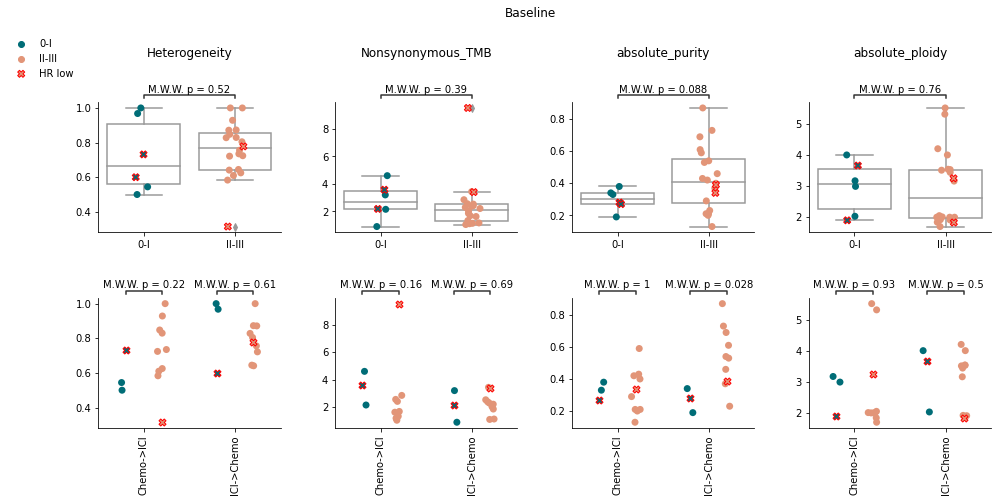

In [25]:
timepoint ='Baseline'
features = ['WES_Heterogeneity','WES_Nonsynonymous_TMB','WES_absolute_purity','WES_absolute_ploidy'
            ]
fig = responsePlot_highlight_er_low(
    data=wes.loc[(wes.Timepoint==timepoint)&(wes['BestResponse']!='N/A'),:],
    features=features,ncols=len(features))
plt.suptitle(timepoint,x=.5,y=1.1);

## Store WES data to excel

In [26]:
wes.loc[wes.Timepoint=='Baseline','BestResponse'].value_counts()

II-III    20
0-I        6
N/A        2
Name: BestResponse, dtype: int64

In [27]:
with pd.ExcelWriter(WesTableFile) as f:
    for k,v in wes_sheets.items():
        v.to_excel(f,sheet_name=k)